# Thực hành buổi 2 - EDA - 2151260823 - Nguyễn Trung Tuyến

In [339]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import warnings
from warnings import simplefilter

import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [340]:
df = pd.read_csv("./data_thuchanh.csv", encoding="latin-1", sep=';')

In [341]:
print((2151260823 % 15 )  + 1)
print((2151260823 % 15 )  + 2)

4
5


In [342]:
feats= ['4', '5']

In [343]:
df[feats].info()
data = df[feats]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   4       365 non-null    float64
 1   5       365 non-null    float64
dtypes: float64(2)
memory usage: 5.8 KB


In [344]:
data.head(5)

,4,5
0,964.4,964.4
1,1019.7,1019.7
2,988.4,988.4
3,1002.0,1002.0
4,1061.5,1061.5


# EDA

In [345]:
summary = data.describe()
print(summary)


                 4            5
count   365.000000   365.000000
mean   1040.228219  1040.228767
std     105.147113   105.146720
min     885.700000   885.700000
25%     988.400000   988.400000
50%    1022.600000  1022.600000
75%    1061.500000  1061.500000
max    1565.500000  1565.500000


## Kiểm tra dữ liệu thiếu

In [346]:

missing_values = data.isnull().sum()
print(missing_values)


4    0
5    0
dtype: int64


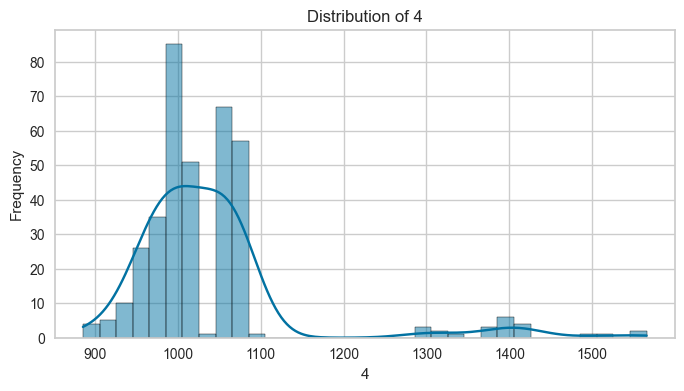

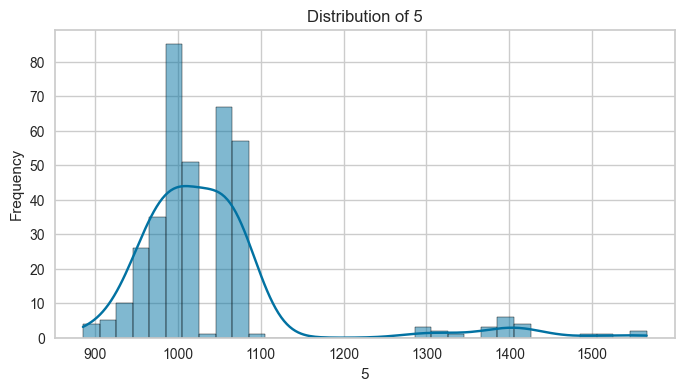

In [347]:


for column in feats:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


## Kiểm tra ngoại lệ và loại bỏ nếu có

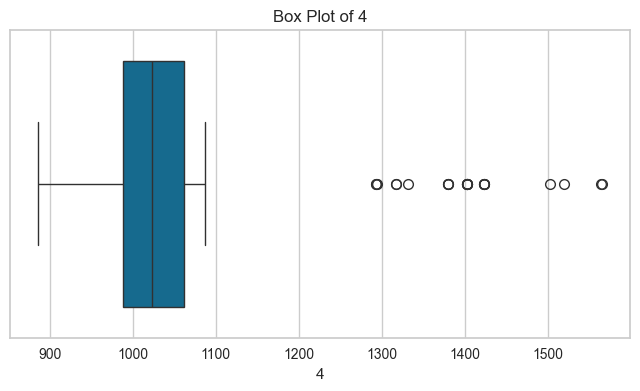

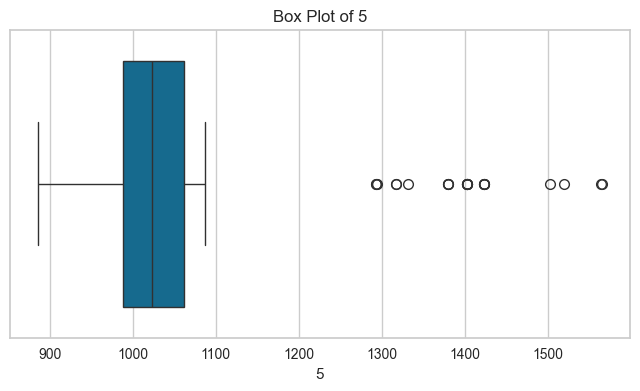

In [348]:
for column in feats:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()


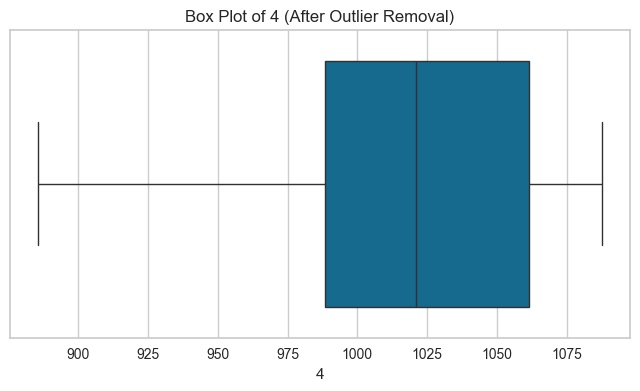

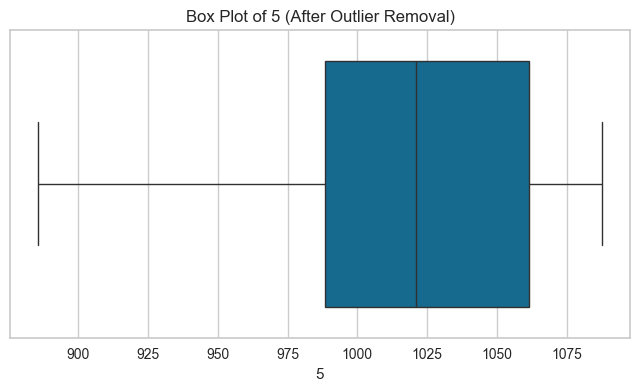

In [349]:

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1


data_cleaned = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

for column in feats:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data_cleaned[column])
    plt.title(f'Box Plot of {column} (After Outlier Removal)')
    plt.xlabel(column)
    plt.show()

## Biểu đồ tương quan

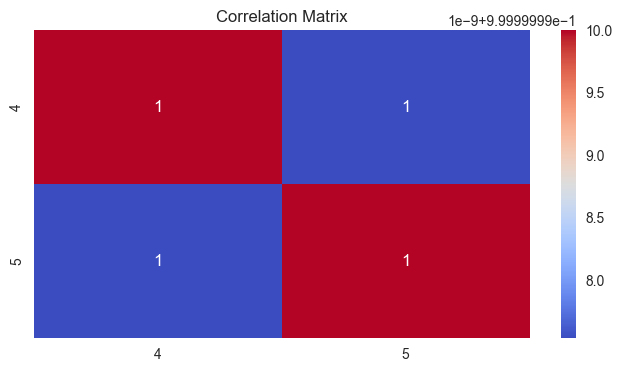

In [350]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


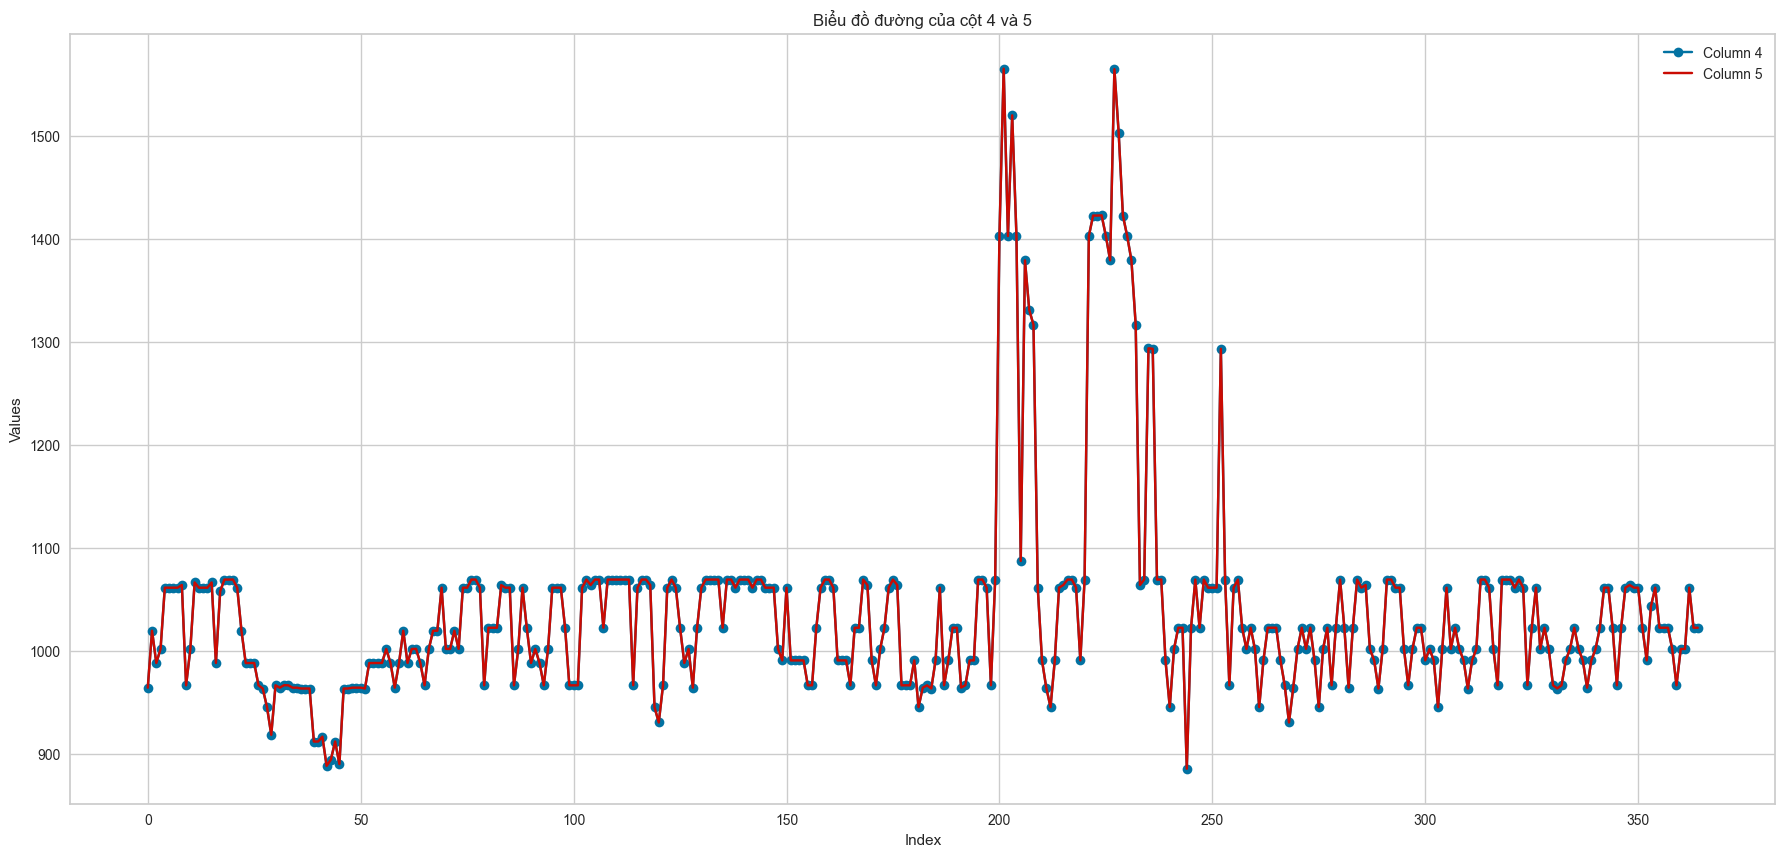

In [351]:
plt.figure(figsize=(22, 10))
plt.plot(data.index, data['4'], marker='o', linestyle='-', color='b', label='Column 4')
plt.plot(data.index, data['5'], marker='x', linestyle='-', color='r', label='Column 5')
plt.title("Biểu đồ đường của cột 4 và 5")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

## Kiểm tra tính dừng của dữ liệu

ADF Statistic for Column 4: -2.784658019592205
p-value for Column 4: 0.06049889940422127
Critical Values for Column 4 1%: -3.44911857009962
Critical Values for Column 4 5%: -2.8698097654570507
Critical Values for Column 4 10%: -2.5711757061225153
------------------------------------------------------------
ADF Statistic for Column 5: -2.7846956523306066
p-value for Column 5: 0.060493358475097486
Critical Values for Column 5 1%: -3.44911857009962
Critical Values for Column 5 5%: -2.8698097654570507
Critical Values for Column 5 10%: -2.5711757061225153
------------------------------------------------------------


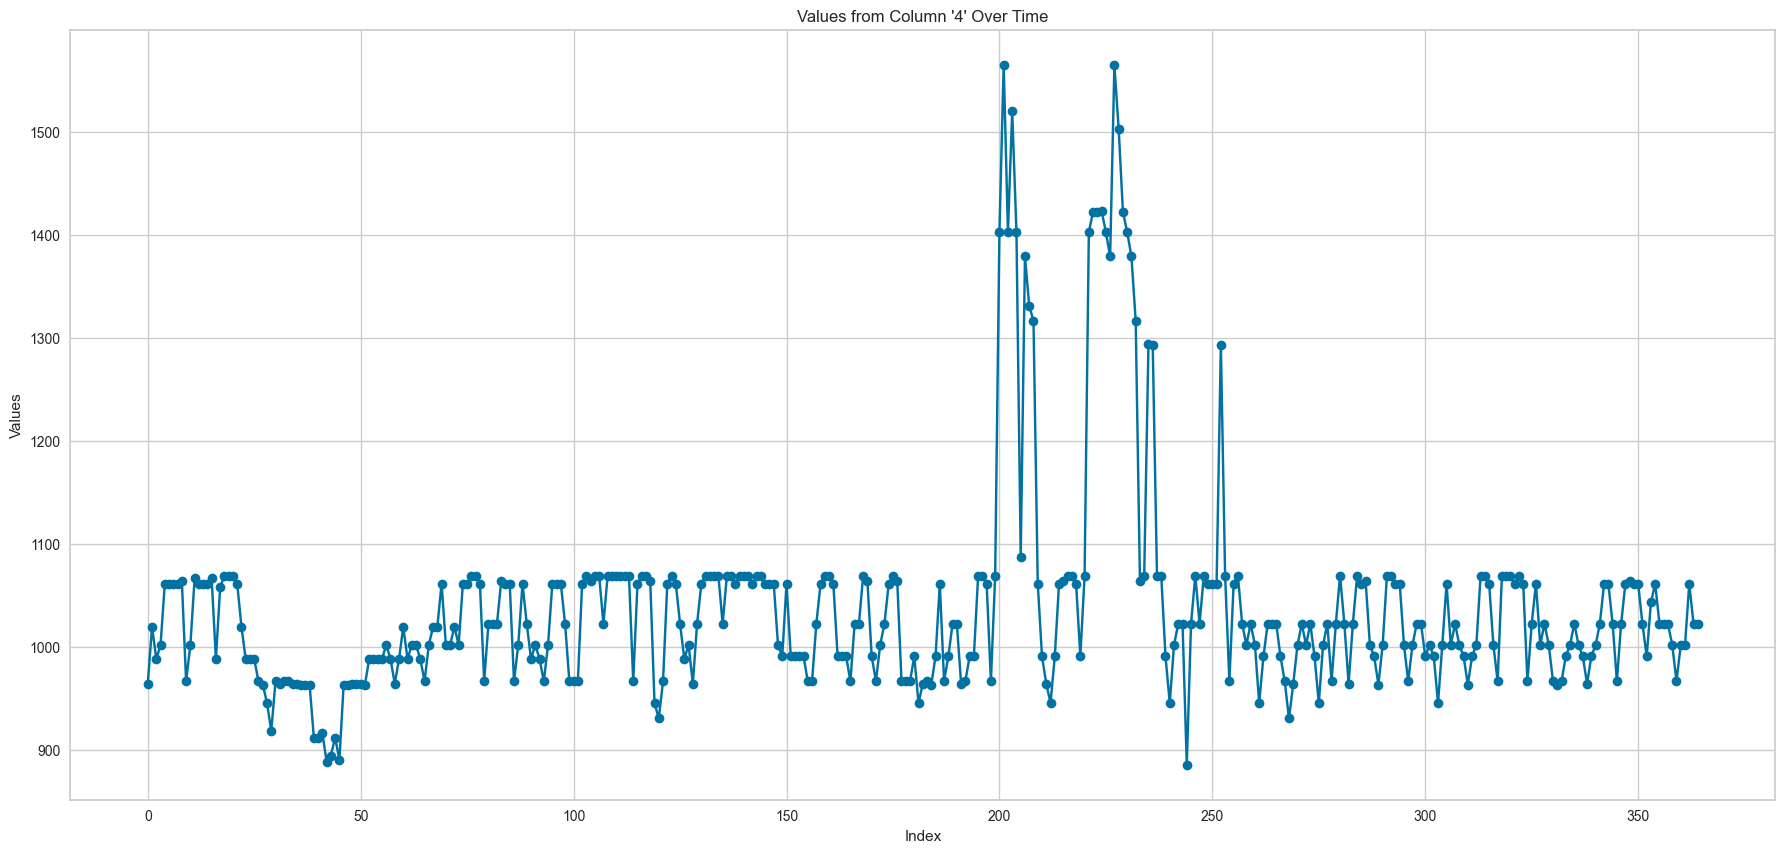

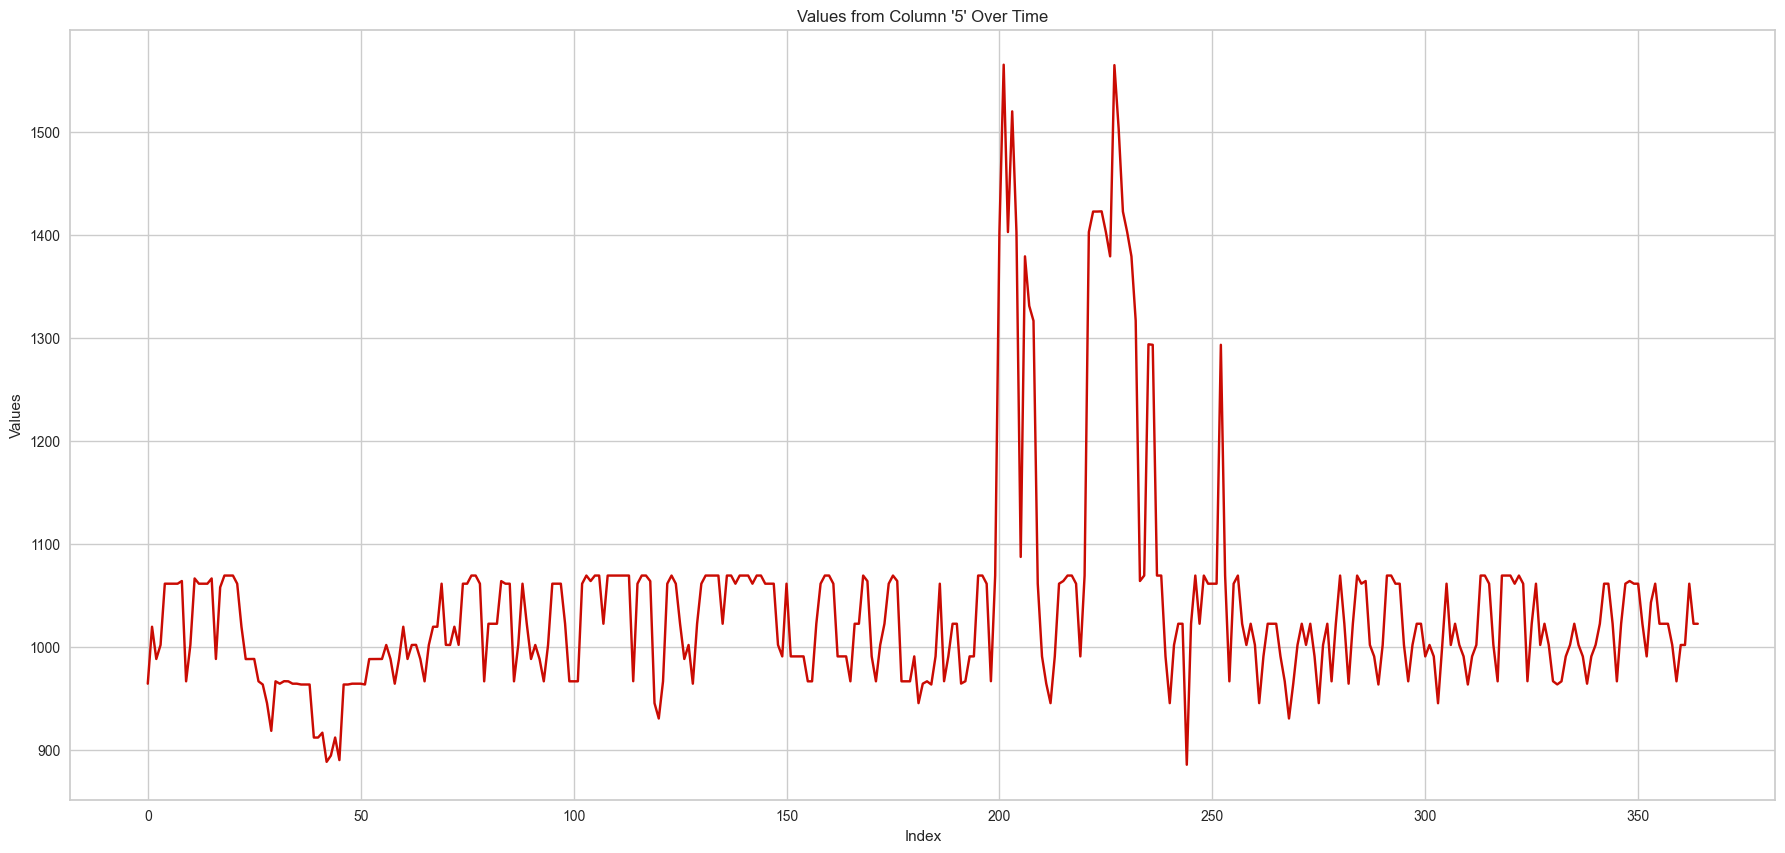

In [352]:
def adf_test(series, column_name):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values for {column_name} {key}: {value}')

    print("------------------------------------------------------------")

adf_test(data['4'], 'Column 4')
adf_test(data['5'], 'Column 5')

plt.figure(figsize=(22, 10))
plt.plot(df.index, data['4'], marker='o', linestyle='-', color='b', label='Column 4')
plt.title("Values from Column '4' Over Time")
plt.xlabel("Index")
plt.ylabel("Values")
plt.grid(True)
plt.show()


plt.figure(figsize=(22, 10))
plt.plot(df.index, data['5'], marker='x', linestyle='-', color='r', label='Column 5')
plt.title("Values from Column '5' Over Time")
plt.xlabel("Index")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Kiểm định giả thuyết Shapiro-Wilk để kiểm tra dữ liệu có tuân theo phân phối chuẩn không

In [353]:
stat, p = shapiro(df['4'])
print('Shapiro-Wilk Test cho Cột 4: Statistics=%.3f, p=%.3f' % (stat, p))


stat, p = shapiro(df['5'])
print('Shapiro-Wilk Test cho Cột 5: Statistics=%.3f, p=%.3f' % (stat, p))


Shapiro-Wilk Test cho Cột 4: Statistics=0.658, p=0.000
Shapiro-Wilk Test cho Cột 5: Statistics=0.658, p=0.000


## Mô hình Gaussian Process Regressor + EDA

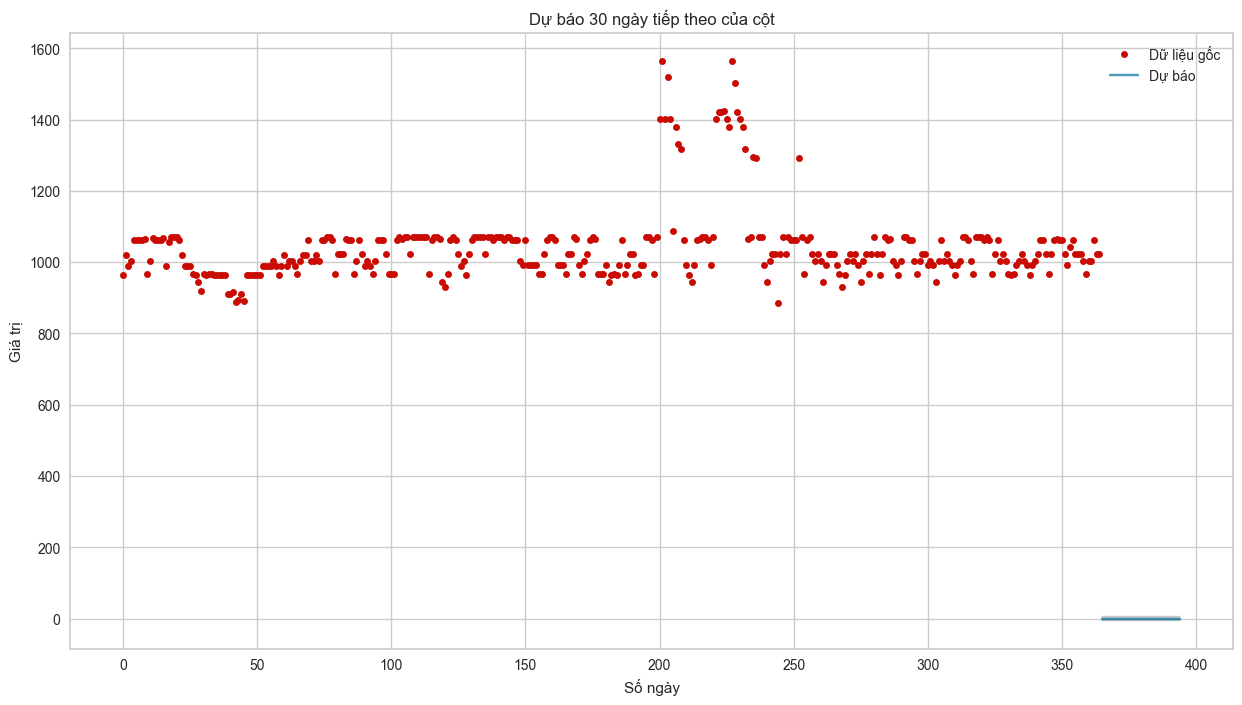

In [354]:

X = data[['5']].values
y = data['4'].values

kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)

X_forecast = np.arange(len(data), len(data) + 30).reshape(-1, 1) 
y_forecast, sigma = gp.predict(X_forecast, return_std=True)

y_test = data['4'].tail(30).values

forecast_data = pd.DataFrame({'Index': np.arange(len(data), len(data) + 30), '4': y_forecast})

combined_data = pd.concat([data[['4']], forecast_data['4']], ignore_index=True)

plt.figure(figsize=(15, 8))
plt.plot(data.index, data['4'], 'r.', markersize=10, label='Dữ liệu gốc')
plt.plot(forecast_data['Index'], forecast_data['4'], 'b-', label='Dự báo', alpha=0.7)
plt.fill_between(forecast_data['Index'], y_forecast - 1.96 * sigma, y_forecast + 1.96 * sigma, alpha=0.2, color='k')
plt.title("Dự báo 30 ngày tiếp theo của cột")
plt.xlabel("Số ngày")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)
plt.show()


In [355]:
mse_gp = mean_squared_error(y_test, y_forecast)
rmse_gp = sqrt(mse_gp)
r2_gp = r2_score(y_test, y_forecast)

print("Gaussian Process - Mean Squared Error:", mse_gp)
print("Gaussian Process - Root Mean Squared Error:", rmse_gp)
print("Gaussian Process - R-squared Score:", r2_gp)


Gaussian Process - Mean Squared Error: 1044337.3540000002
Gaussian Process - Root Mean Squared Error: 1021.9282528631842
Gaussian Process - R-squared Score: -1139.1515889932753


## Mô hình Arima + EDA

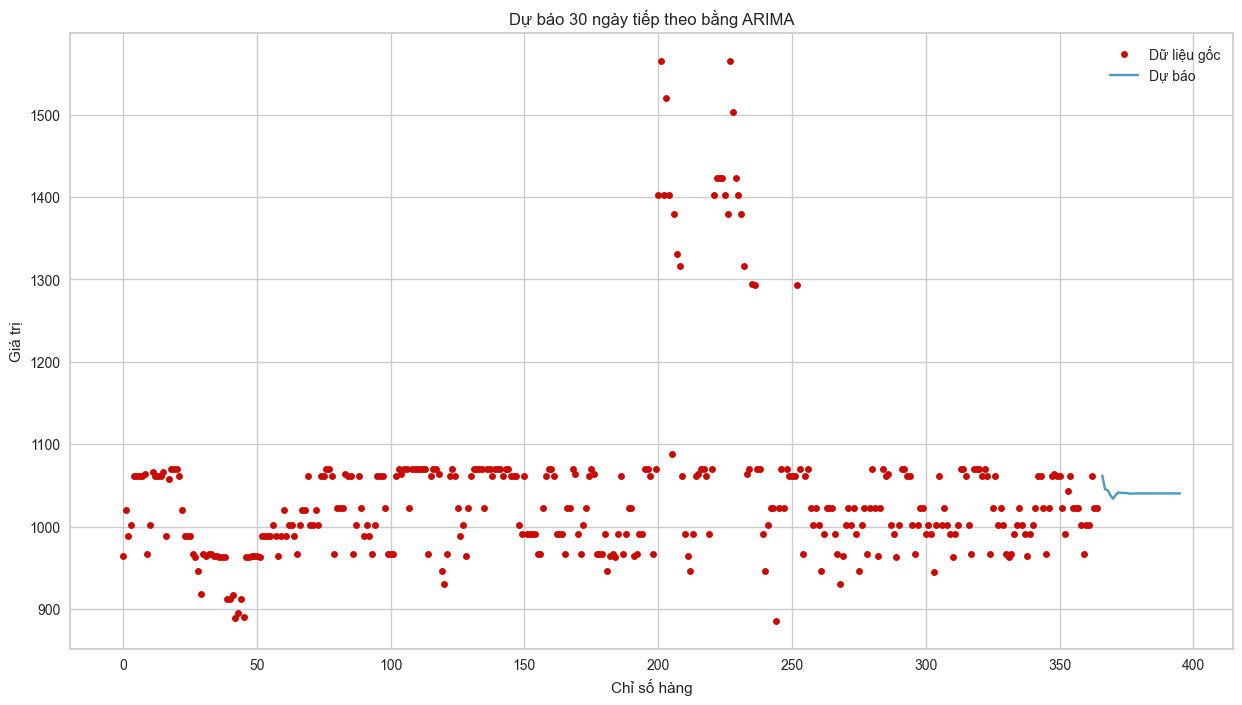

In [356]:
X = data[['5']].values
y = data['4'].values

train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = ARIMA(y_train, order=(5, 1, 0))  
model_fit = model.fit()

y_forecast = model_fit.forecast(steps=30)

forecast_data = pd.DataFrame({'Index': np.arange(len(data) + 1, len(data) + 31), '4': y_forecast})
combined_data = pd.concat([data[['4']], forecast_data['4']], ignore_index=True)

plt.figure(figsize=(15, 8))
plt.plot(data.index, data['4'], 'r.', markersize=10, label='Dữ liệu gốc')
plt.plot(forecast_data['Index'], forecast_data['4'], 'b-', label='Dự báo', alpha=0.7)
plt.title("Dự báo 30 ngày tiếp theo bằng ARIMA")
plt.xlabel("Chỉ số hàng")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)
plt.show()

y_arima_forecast = model_fit.forecast(steps=len(X_test))

In [357]:
mse_arima = mean_squared_error(y_test, y_arima_forecast)
rmse_arima = sqrt(mse_arima)
r2_arima = r2_score(y_test, y_arima_forecast)

print("ARIMA - Mean Squared Error:", mse_arima)
print("ARIMA - Root Mean Squared Error:", rmse_arima)
print("ARIMA - R-squared Score:", r2_arima)

ARIMA - Mean Squared Error: 1677.8542102509991
ARIMA - Root Mean Squared Error: 40.96161874549148
ARIMA - R-squared Score: -0.35367679815862263


## Mô hình XGBoost + EDA

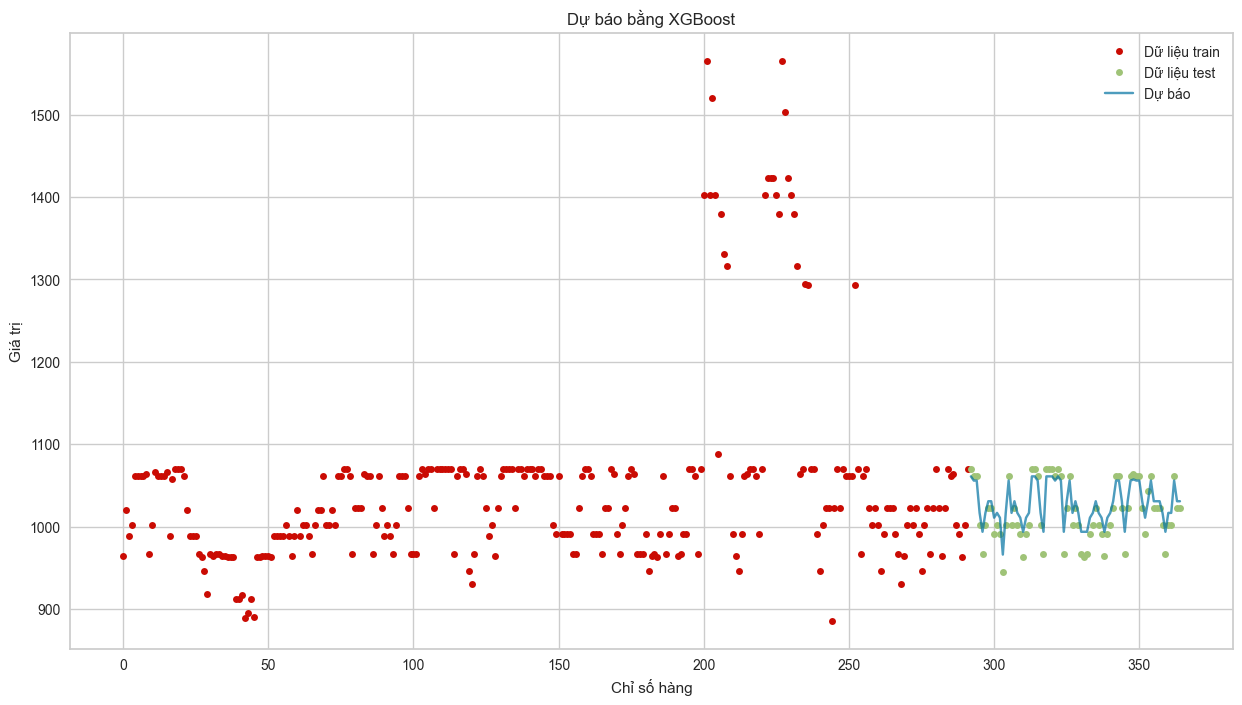

In [358]:
X = data[['5']].values
y = data['4'].values

train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'reg:squarederror',  
    'colsample_bytree': 0.3,           
    'learning_rate': 0.1,              
    'max_depth': 5,                    
    'alpha': 10,                       
    'n_estimators': 100                
}


model = xgb.train(params, dtrain)
y_forecast = model.predict(dtest)

forecast_data = pd.DataFrame({'Index': np.arange(train_size, len(X)), '4': y_forecast})

combined_data = pd.concat([data[['4']], forecast_data['4']], ignore_index=True)


plt.figure(figsize=(15, 8))
plt.plot(data.index[:train_size], data['4'][:train_size], 'r.', markersize=10, label='Dữ liệu train')
plt.plot(data.index[train_size:], data['4'][train_size:], 'g.', markersize=10, label='Dữ liệu test')
plt.plot(forecast_data['Index'], forecast_data['4'], 'b-', label='Dự báo', alpha=0.7)
plt.title("Dự báo bằng XGBoost")
plt.xlabel("Chỉ số hàng")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)
plt.show()


In [359]:

y_xgboost_forecast = model.predict(dtest)

mse_xgboost = mean_squared_error(y_test, y_xgboost_forecast)
rmse_xgboost = sqrt(mse_xgboost)
r2_xgboost = r2_score(y_test, y_xgboost_forecast)

print("XGBoost - Mean Squared Error:", mse_xgboost)
print("XGBoost - Root Mean Squared Error:", rmse_xgboost)
print("XGBoost - R-squared Score:", r2_xgboost)

XGBoost - Mean Squared Error: 231.30461964600295
XGBoost - Root Mean Squared Error: 15.208702102612271
XGBoost - R-squared Score: 0.8133856356477722


## Mô hình VotingRegressor  kết hợp của Gaussian và SVR

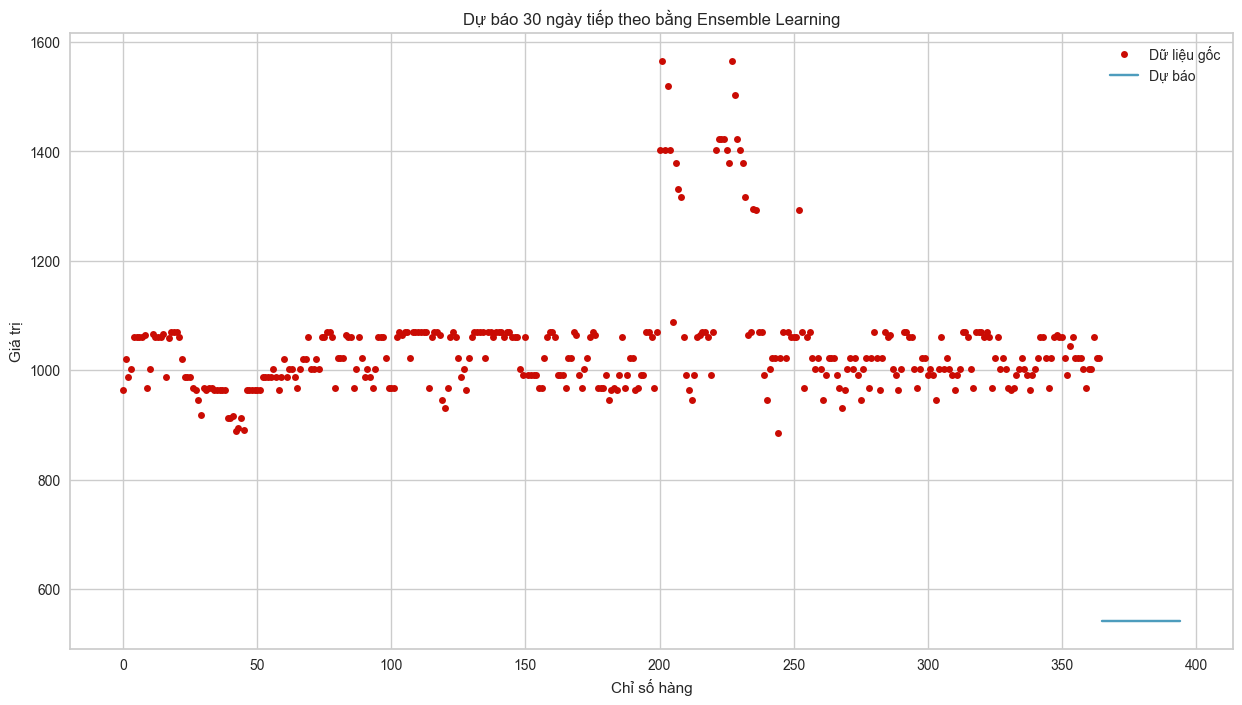

In [360]:


X = data[['5']].values
y = data['4'].values

kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

svr = SVR(kernel='rbf', C=100, gamma='auto')

ensemble_model = VotingRegressor([('gp', gp), ('svr', svr)])

ensemble_model.fit(X, y)

X_forecast = np.arange(len(data), len(data) + 30).reshape(-1, 1) 
y_forecast = ensemble_model.predict(X_forecast)


forecast_data = pd.DataFrame({'Index': np.arange(len(data), len(data) + 30), '4': y_forecast})

combined_data = pd.concat([data[['4']], forecast_data['4']], ignore_index=True)

plt.figure(figsize=(15, 8))
plt.plot(data.index, data['4'], 'r.', markersize=10, label='Dữ liệu gốc')
plt.plot(forecast_data['Index'], forecast_data['4'], 'b-', label='Dự báo', alpha=0.7)
plt.title("Dự báo 30 ngày tiếp theo bằng Ensemble Learning")
plt.xlabel("Chỉ số hàng")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)
plt.show()

y_train_forecast = ensemble_model.predict(X_train)
y_test_forecast = ensemble_model.predict(X_test)

In [361]:
mse_forecast = mean_squared_error(y[-30:], y_forecast)
rmse_forecast = sqrt(mse_forecast)
r2_forecast = r2_score(y[-30:], y_forecast)

print("Forecast - Mean Squared Error:", mse_forecast)
print("Forecast - Root Mean Squared Error:", rmse_forecast)
print("Forecast - R-squared Score:", r2_forecast)

Forecast - Mean Squared Error: 230691.27857664032
Forecast - Root Mean Squared Error: 480.3033193479307
Forecast - R-squared Score: -250.85638225868414
